# STATS 542: Homework 5

<h4><center> Diego Kleiman (diegoek2) </center></h4>
<h4><center> Due: Tuesday 11:59 PM CT, Mar 9th </center></h4>

## About HW5

We utilize the coordinate descent algorithm introduced in the class with the one variable Lasso algorithm from the last homework to complete the entire Lasso solution. This involves two steps: in the first step, we solve the solution for a fixed $\lambda$ value, while in the second step, we consider a grid of $\lambda$ value and solve it using the path-wise coordinate descent. 

## Question 1 [40 Points] Lasso solution for fixed $\lambda$

For this question, you cannot use functions from any additional library in your algorithm. Following HW4, we use the this version of the objective function: 

$$\arg\min_{\beta} \frac{1}{2n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$
The following data is used to fit this model. Note that the `MASS` package can only be used to generate multivariate normal data. You can consider using similar functions in Python if needed. 

```r
  library(MASS)
  set.seed(10)
  n = 100
  p = 200
  
  # generate data
  V = matrix(0.3, p, p)
  diag(V) = 1
  X_org = as.matrix(mvrnorm(n, mu = rep(0, p), Sigma = V))
  true_b = c(runif(10, -1, 1), rep(0, p-10))
  y_org = X_org %*% true_b + rnorm(n)

  # pre-scale and center X and y
  X = scale(X_org)*sqrt(n/(n-1))
  y = scale(y_org)*sqrt(n/(n-1))
  lambda = 0.3
```

We will use the pre-scale and centered data `X` and `y` for this question, hence no intercept is needed. Write a Lasso algorithm function `myLasso(X, y, lambda, tol, maxitr)` which will output a vector of $\beta$ values **without** the intercept. You need to consider the following while completing this question:

  * Do not use functions from any additional library
  * Start with a vector $\boldsymbol \beta = \mathbf{0}$
  * Use the soft-threshold function you developed in HW4. 
  * Use the efficient $\mathbf{r}$ update algorithm we introduced during the lecture.
  * Run your coordinate descent algorithm for a maximum of `maxitr` = 100 iterations (while each iteration will loop through all variables). However, stop your algorithm if the $\boldsymbol \beta$ value of the current iteration is sufficiently similar to the previous one, i.e., $\lVert \boldsymbol \beta^{(k)} - \boldsymbol \beta^{(k-1)} \rVert^2 \leq \text{tol}$. Set `tol = 1e-7`.
  * After running the algorithm, print out the first 10 variables.
  * Finally, check and compare your answer to the `glmnet` package using the following code:

```r
  library(glmnet)
  glmnetfit = glmnet(X, y, lambda = 0.3, intercept = FALSE)
  glmnetfit$beta[1:10]
```

In [1]:
import numpy as np
from scipy.stats import multivariate_normal # Python equivalent of mvrnorm
from sklearn.preprocessing import scale

In [2]:
seed = 1

In [3]:
np.random.seed(seed)

In [4]:
n = 100
p = 200

V = np.ones((p, p))*0.3
np.fill_diagonal(V, 1)
X_org = np.asarray(multivariate_normal(mean=np.zeros(p), cov=V, seed=seed).rvs(n))
true_b = np.append(np.random.uniform(low=-1, high=1, size=10), np.zeros(p-10))
y_org = np.matmul(X_org, true_b) + np.random.normal(n)

# Python adaptation note: the function sklearn.preprocessing.scale does NOT divide by (n-1) to compute the standard 
# deviation. Instead it uses n. For this reason, we do not need to multiply by sqrt(n/(n-1)) (if we did, we wouldn't 
# get Xj^T*Xj=n).

X = scale(X_org)
y = scale(y_org)
l = 0.3 # lambda is a reserved keyword in Python

In [5]:
def myLasso(X, y, l, tol=1e-7, maxitr=100):
    '''
    Fit Lasso regression parameters (no intercept). 
    This function uses the coordinate descent algorithm to find the parameters.
    
    Arguments
    ----
    X: np.ndarray of shape (n, p). Design matrix.
    y: np.nndarray of shape (n). Outcomes.
    l: float. Lambda (one-norm penalty consntant for Lasso).
    tol: float. Default 1e-7. Stop coordinate descent when ||beta^k - beta^(k-1)||^2 ≤ tol.
    maxitr: int. Default 100. Stop coordinate descent after maxitr iterations (if tolerance 
        criterion has not been met already).
    
    Returns
    ----
    b_lasso: np.ndarray of shape (p). Lasso fit parameters.
    '''
    
    (n, p) = X.shape
    b_lasso = np.zeros(p) # Start with vector of zeros
    b_prev = np.ones(p) # To compare succesive iterations of coordinate descent
    itr = 0
    
    while (np.linalg.norm(b_lasso - b_prev)**2 > tol) and (itr < maxitr):
        b_prev = b_lasso.copy()
        itr += 1
        
        for j in range(p): # Update one parameter at a time (Gauss-Seidel style)
            
            X_j = X[:, j]
            
            if (j == 0):
                b_minus_j = np.delete(b_lasso, j, axis=0) # Remove jth parameter
                X_minus_j = np.delete(X, j, axis=1) # Remove jth column
                r = y - np.matmul(X_minus_j, b_minus_j) # r is initialized for first j
            else:
                # In future iterations, we update r by including the effect of the previous variable on the outcome
                # and excluding the effect of the variable we're currently updating
                X_j_prev = X[:, j-1]
                b_j_prev = b_lasso[j-1]
                b_j_cur = b_lasso[j]
           
                r = r_prev - X_j_prev*b_j_prev + X_j*b_j_cur
            
            b_ols_j = np.asarray([np.matmul(X_j.T, r)/n]) # OLS parameter
            b_lasso[j] = soft_th(b_ols_j, l) # Apply regularization (update jth parameter from beta^k to beta^(k+1))
            r_prev = r.copy() # Store r for efficient update step
    
    return b_lasso
    
# Soft threshold function from HW4

def soft_th(b, l):
    '''
    Return the Lasso regression fit parameters from the corresponding OLS parameters (b) and penalty constant (l).
    '''
    assert(l > 0) # lambda must be greater than zero
    
    size = b.shape[0]
    b_lasso = np.empty(size)
    
    for j in range(size):
        if b[j] > l:
            b_lasso[j] = b[j] - l
        elif np.abs(b[j]) < l:
            b_lasso[j] = 0
        elif b[j] < -l:
            b_lasso[j] = b[j] + l
    
    return b_lasso  

In [6]:
b_lasso = myLasso(X, y, l)

In [7]:
from sklearn.linear_model import Lasso # Python equivalent of glmnet
model = Lasso(alpha=l, fit_intercept=False, max_iter=100, tol=1e-7, random_state=seed).fit(X, y)
b_lasso_library = model.coef_

In [8]:
print("My Lasso function:     ", b_lasso[:10].round(3))
print("Library Lasso function:", b_lasso_library[:10].round(3))

My Lasso function:      [ 0.     0.    -0.185 -0.011 -0.203 -0.232 -0.146  0.     0.     0.   ]
Library Lasso function: [-0.    -0.    -0.185 -0.011 -0.203 -0.232 -0.147 -0.    -0.    -0.   ]


Conclusion: the fitting parameters from my function are virtually identical to the ones from the sklearn module.

## Question 2 [40 Points] Path-wise Coordinate Descent

Let's modify our Lasso code to perform path-wise coordinate descent. The idea is simple: we will solve the solution on a grid of $\lambda$ values, starting from the largest one. After obtaining the optimal $\boldsymbol \beta$ for a given $\lambda$, we simply use this solution as the initial value (instead of all zero) for the next (smaller) $\lambda$. This is referred to as a warm start in optimization problems. For more details, please watch the lecture video. We will consider the following grid of $\lambda$, with the `glmnet` solution of the first 10 variables plotted. 

```r
  glmnetfit = glmnet(X, y, intercept = FALSE)
  lambda_all = glmnetfit$lambda

  matplot(t(glmnetfit$beta[1:10, ]), type = "l", xlab = "Lambda Index", ylab = "Estimated Beta")
```

You need to add an additional input argument `lambda_all` to your Lasso function. After finishing your algorithm, output a matrix that records all the fitted parameters on your $\lambda$ grid. 

  * Provide a plot same as the above `glmnet` solution plot of the first 10 variables. 
  * Which two variables entering (start to have nonzero values) the model first?
  * What is the maximum discrepancy between your solution and `glmnet`? 

In [9]:
from sklearn.linear_model import lasso_path # Python equivalent of glmnet

lambda_all, beta_library, _ = lasso_path(X, y, fit_intercept=False, max_iter=100, tol=1e-7, random_state=seed)

In [10]:
def myLasso_grid(X, y, lambda_all, tol=1e-7, maxitr=100):
    '''
    Perform Lasso path coordinate descent through all lambda values in lambda_all.
    
    Arguments
    ----
    X: np.ndarray of shape (n, p). Design matrix.
    y: np.ndarray of shape (n). Outcomes.
    lambda_all: np.ndarray of shape (n_lambda). Vector of successively smaller one-norm 
        penalty constants for Lasso.
    tol: float. Default 1e-7. Stop coordinate descent when ||beta^k - beta^(k-1)||^2 ≤ tol.
    maxitr: int. Default 100. Stop coordinate descent after maxitr iterations (if tolerance 
        criterion has not been met already).
    
    Returns
    ----
    b_lasso: np.ndarray of shape (p, n_lambda). Lasso fit parameters for each lambda value.
    '''
    
    (n, p) = X.shape
    b = np.zeros(p) # Start with zeros
    n_lambda = lambda_all.shape[0]
    b_lasso = np.empty((p, n_lambda)) # Output matrix
    
    for i, l in enumerate(lambda_all):
        b = myLasso_grid_helper(X, y, l, b, tol, maxitr)
        b_lasso[:, i] = b
        
    return b_lasso
        
def myLasso_grid_helper(X, y, l, b, tol, maxitr):
    '''
    Fit Lasso regression parameters (no intercept). Helper function to explore lambda grid.  
    This function uses the coordinate descent algorithm to find the parameters.
    
    Arguments
    ----
    X: np.ndarray of shape (n, p). Design matrix.
    y: np.ndarray of shape (n). Outcomes.
    l: float. Lambda (one-norm penalty consntant for Lasso).
    b: np.ndarray of shape (p). Initial parameters.
    tol: float. Default 1e-7. Stop coordinate descent when ||beta^k - beta^(k-1)||^2 ≤ tol.
    maxitr: int. Default 100. Stop coordinate descent after maxitr iterations (if tolerance 
        criterion has not been met already).
    
    Returns
    ----
    b_lasso: np.ndarray of shape (p). Lasso fit parameters.
    '''
    
    (n, p) = X.shape
    
    b_lasso = b # Warm start
    b_prev = np.ones(p) # To compare succesive iterations of coordinate descent
    itr = 0
        
    while (np.linalg.norm(b_lasso - b_prev)**2 > tol) and (itr < maxitr):
        b_prev = b_lasso.copy()
        itr += 1

        for j in range(p): # Update one parameter at a time (Gauss-Seidel style)

            X_j = X[:, j]

            if (j == 0):
                b_minus_j = np.delete(b_lasso, j, axis=0) # Remove jth parameter
                X_minus_j = np.delete(X, j, axis=1) # Remove jth column
                r = y - np.matmul(X_minus_j, b_minus_j) # r is initialized for first j
            else:
                # In future iterations, we update r by including the effect of the previous variable on the outcome
                # and excluding the effect of the variable we're currently updating
                X_j_prev = X[:, j-1]
                b_j_prev = b_lasso[j-1]
                b_j_cur = b_lasso[j]

                r = r_prev - X_j_prev*b_j_prev + X_j*b_j_cur

            b_ols_j = np.asarray([np.matmul(X_j.T, r)/n]) # OLS parameter
                
            b_lasso[j] = soft_th(b_ols_j, l) # Apply regularization (update jth parameter from beta^k to beta^(k+1))
            r_prev = r.copy() # Store r for efficient update step

    return b_lasso

In [11]:
from itertools import cycle
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
plt.style.use('seaborn-darkgrid')

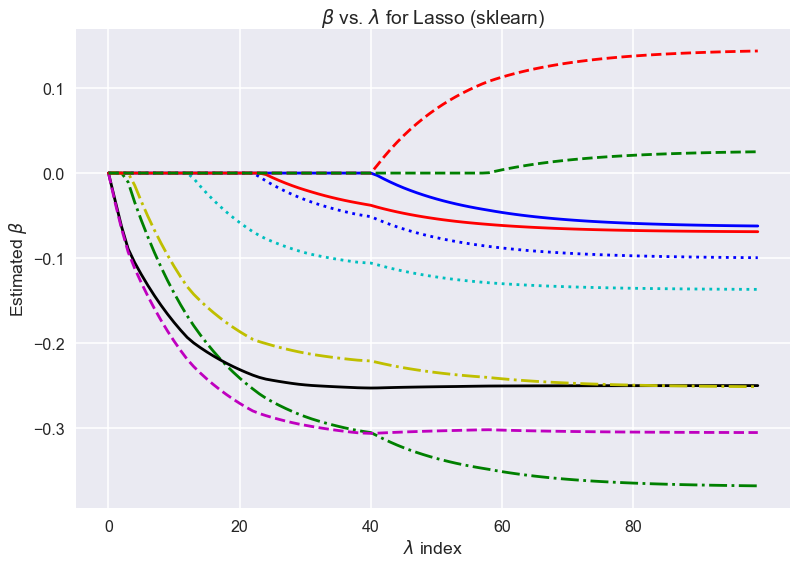

In [12]:
colors = cycle(['b', 'r', 'g', 'c', 'k', 'm', 'y'])
styles = cycle(['-', '--', '-.', ':'])
neg_log_lambda_all = -np.log(lambda_all)
for coef, c, s in zip(beta_library[:10, :], colors, styles):
    l1 = plt.plot(neg_log_lambda_all, coef, s, c=c)

xticks = neg_log_lambda_all.copy()
xticks.sort()
step = 20
plt.xticks(xticks[::step], labels=np.arange(0, 100)[::step])
plt.xlabel("$\lambda$ index")
plt.ylabel(r'Estimated $\beta$')
plt.title(r'$\beta$ vs. $\lambda$ for Lasso (sklearn)')
plt.show()
plt.close()

In [13]:
my_beta_lasso = myLasso_grid(X, y, lambda_all) # Prints some debugging values

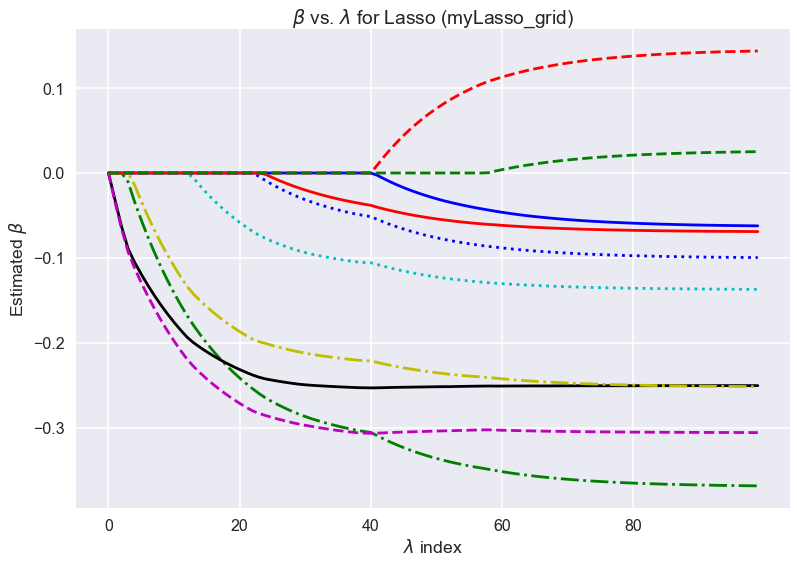

In [14]:
colors = cycle(['b', 'r', 'g', 'c', 'k', 'm', 'y'])
styles = cycle(['-', '--', '-.', ':'])
neg_log_lambda_all = -np.log(lambda_all)
for coef, c, s in zip(my_beta_lasso[:10, :], colors, styles):
    l1 = plt.plot(neg_log_lambda_all, coef, s, c=c)

xticks = neg_log_lambda_all.copy()
xticks.sort()
step = 20
plt.xticks(xticks[::step], labels=np.arange(0, 100)[::step])
plt.xlabel("$\lambda$ index")
plt.ylabel(r'Estimated $\beta$')
plt.title(r'$\beta$ vs. $\lambda$ for Lasso (myLasso_grid)')
# plt.legend(np.arange(10), loc='upper left')
plt.show()
plt.close()

In [15]:
# Variables that enter first into the model
print("First two variables to enter model according to my implementation:", np.where(np.abs(my_beta_lasso[:, 1]) > 0)[0])
print("First two variables to enter model according to sklearn:          ", np.where(np.abs(beta_library[:, 1]) > 0)[0])

First two variables to enter model according to my implementation: [4 5]
First two variables to enter model according to sklearn:           [4 5]


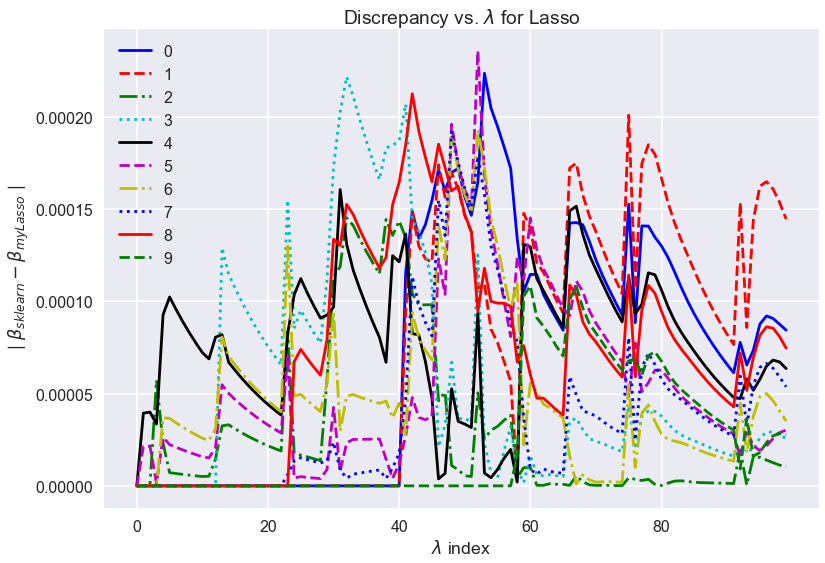

In [16]:
# Max discrepancy
discrepancies = np.abs(my_beta_lasso - beta_library)

colors = cycle(['b', 'r', 'g', 'c', 'k', 'm', 'y'])
styles = cycle(['-', '--', '-.', ':'])
neg_log_lambda_all = -np.log(lambda_all)
for coef, c, s in zip(discrepancies[:10, :], colors, styles):
    l1 = plt.plot(neg_log_lambda_all, coef, s, c=c)

xticks = neg_log_lambda_all.copy()
xticks.sort()
step = 20
plt.xticks(xticks[::step], labels=np.arange(0, 100)[::step])
plt.xlabel("$\lambda$ index")
plt.ylabel(r'$ \mid \beta_{sklearn} - \beta_{myLasso} \mid$')
plt.title(r'Discrepancy vs. $\lambda$ for Lasso')
plt.legend(np.arange(10))
plt.show()
plt.close()

In [17]:
# Max discrepancy
val = np.max(np.abs(my_beta_lasso[:10, :] - beta_library[:10, :]))
var_index, l_index  = np.where(np.abs(my_beta_lasso - beta_library) == val)

print("Max discrepancy value:", val)
print("Occuring for lambda value:", lambda_all[l_index[0]])
print("Occuring for variable:", var_index[0])

Max discrepancy value: 0.00023564668637593433
Occuring for lambda value: 0.020393229658758557
Occuring for variable: 5


Conclusions: 

We can see form the plot that my function and the library show excellent agreement. 

The two variables that enter first into the model (that is, the two variables that are non-zero for a small lambda) are variables 5 and 6 (indices 4 and 5).

The maximum discrepancy occurs for the lambda value of 0.020393229658758557 and it is for the variable 6 (index 5).

## Question 3 [20 Points] Recovering the Original Scale

The formula provided in HW4 can also be used when there are multiple variables. 

$$
\begin{align}
\frac{Y - \bar{Y}}{\text{sd}_y} =&~ \sum_{j=1}^p \frac{X_j - \bar{X}_j}{\text{sd}_j} \gamma_j \\
Y =&~ \underbrace{\bar{Y} - \sum_{j=1}^p \bar{X}_j \frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_0} + \sum_{j=1}^p X_j \underbrace{\frac{\text{sd}_y \cdot \gamma_j}{\text{sd}_j}}_{\beta_j},
\end{align}
$$
Use this formula to recover the original scale of the $\boldsymbol \beta$, including the intercept term $\beta_0$. 

  * Use the following code of `glmnet` to obtain a solution path. 
  * After recovering your $\boldsymbol \beta$ values, produce a plot of your solution path. 
  * What is the maximum discrepancy between your solution and `glmnet`?
  * [Bonus 5 Points] If we do not specify `lambda` in the following `glmnet()` function, the package will pick a different grid, which lead to a different set of solution. Explain how the `lambda` values are picked in this case. What is the largest `lambda` being considered? and why we don't need to consider a larger `lambda` value? Consider reading the following paper (section 2.5) and the documentation of the `glmnet()` function at the CRAN website. However, please note that the descriptions from these two sources are slightly different, with similar ideas.
      + Friedman, Jerome, Trevor Hastie, and Rob Tibshirani. "Regularization paths for generalized linear models via coordinate descent." Journal of statistical software 33, no. 1 (2010): 1.

```r
  glmnetfit2 = glmnet(X_org, y_org, lambda = lambda_all*sd(y_org)*sqrt(n/(n-1)))
  lassobeta2 = coef(glmnetfit2)[2:11, ]
  matplot(t(as.matrix(coef(glmnetfit2)[2:11, ])), type = "l", xlab = "Lambda Index", ylab = "Estimated Beta")
```

In [18]:
from glmnet import ElasticNet # Using glmnet because sklearn fucntion behaves differently

# Python adaptation note: the function np.std does NOT divide by (n-1) to compute the standard 
# deviation. Instead, it divides by n. For this reason, we do not need to multiply np.std(y_org) 
# by sqrt(n/(n-1)).

model2 = ElasticNet(lambda_path=lambda_all*np.std(y_org)).fit(X_org, y_org)
lassobeta2 = model2.coef_path_

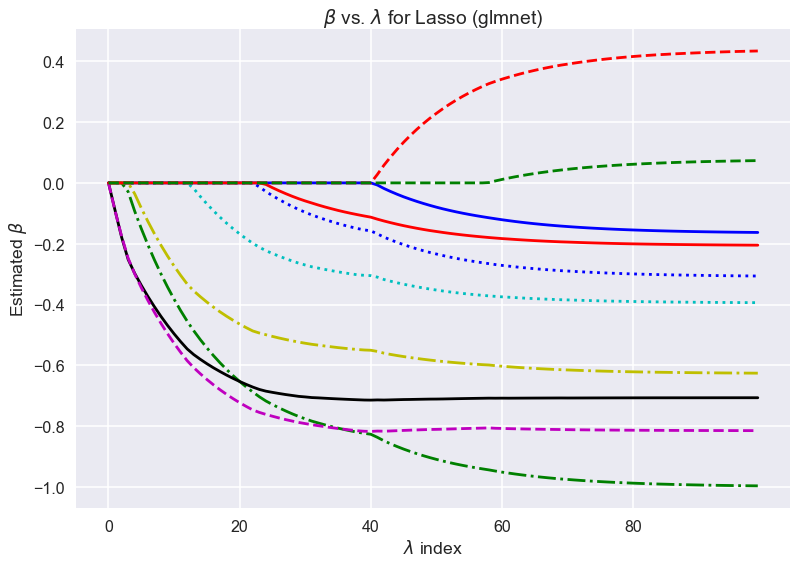

In [19]:
colors = cycle(['b', 'r', 'g', 'c', 'k', 'm', 'y'])
styles = cycle(['-', '--', '-.', ':'])
neg_log_lambda_all = -np.log(lambda_all*np.std(y_org))
for coef, c, s in zip(lassobeta2[:10, :], colors, styles):
    l1 = plt.plot(neg_log_lambda_all, coef, s, c=c)

xticks = neg_log_lambda_all.copy()
xticks.sort()
step = 20
plt.xticks(xticks[::step], labels=np.arange(0, 100)[::step])
plt.xlabel("$\lambda$ index")
plt.ylabel(r'Estimated $\beta$')
plt.title(r'$\beta$ vs. $\lambda$ for Lasso (glmnet)')
plt.show()
plt.close()

In [20]:
# Scaling function from HW4 --> Used to get mu_j, sd_j, mu_y, sd_y to recover scale

def scale_data(X, Y):
    '''
    Standardize data and predictions (center on mean = 0 and scale to stadard deviation = 1).
    Returns stadardized data (X_std, Y_std) and necessary parameters (mu_j, sd_j, mu_y, sd_y) 
    to recover the predictions in the original scale.
    '''
    mu_j = np.mean(X, axis=0)
    sd_j = np.std(X, axis=0)
    mu_y = np.mean(Y)
    sd_y = np.std(Y)
    
    X_std = (X - mu_j) / sd_j
    Y_std = (Y - mu_y) / sd_y
    
    return X_std, Y_std, mu_j, sd_j, mu_y, sd_y

In [21]:
_, _, mu_j, sd_j, mu_y, sd_y = scale_data(X_org, y_org)
my_beta_0 = mu_y - np.sum(mu_j*sd_y/sd_j)
my_beta_j = my_beta_lasso*sd_y/sd_j[:, None]

In [22]:
my_beta_0

74.2261988308727

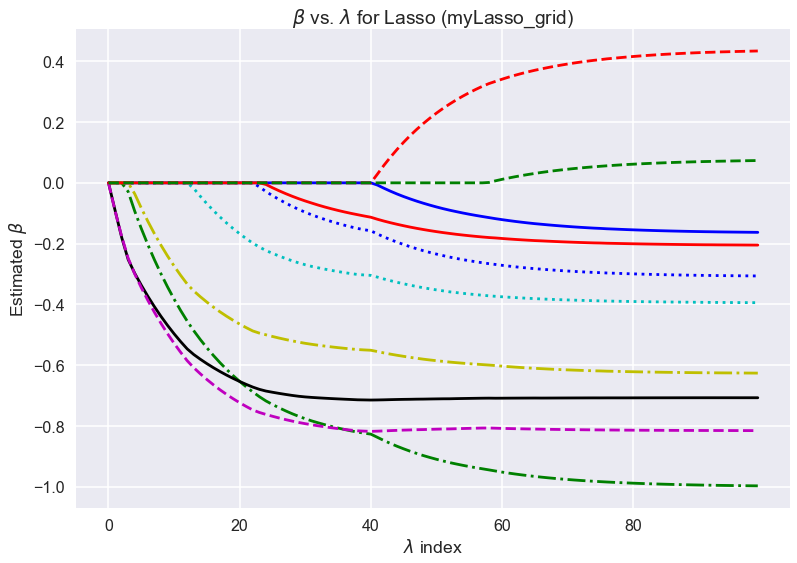

In [23]:
colors = cycle(['b', 'r', 'g', 'c', 'k', 'm', 'y'])
styles = cycle(['-', '--', '-.', ':'])
neg_log_lambda_all = -np.log(lambda_all*np.std(y_org))
for coef, c, s in zip(my_beta_j[:10, :], colors, styles):
    l1 = plt.plot(neg_log_lambda_all, coef, s, c=c)

xticks = neg_log_lambda_all.copy()
xticks.sort()
step = 20
plt.xticks(xticks[::step], labels=np.arange(0, 100)[::step])
plt.xlabel("$\lambda$ index")
plt.ylabel(r'Estimated $\beta$')
plt.title(r'$\beta$ vs. $\lambda$ for Lasso (myLasso_grid)')
plt.show()
plt.close()

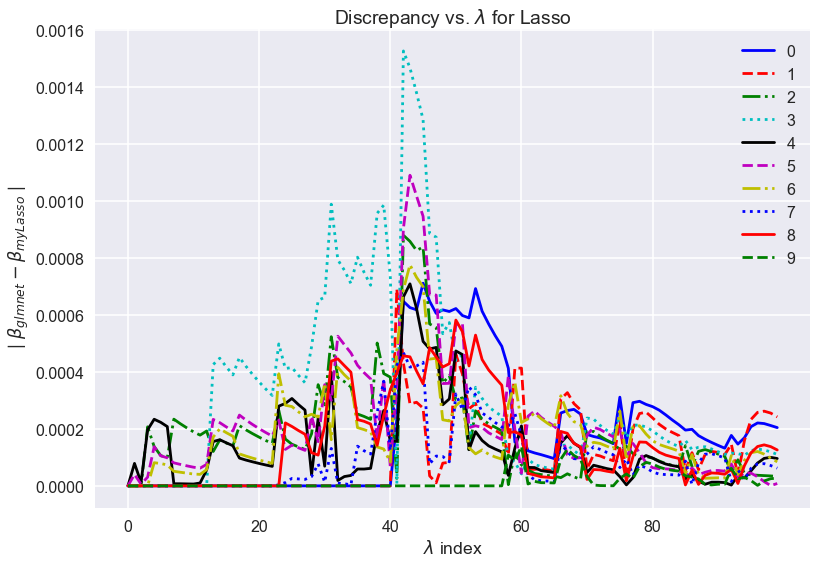

In [24]:
# Max discrepancy
discrepancies = np.abs(my_beta_j - lassobeta2)

colors = cycle(['b', 'r', 'g', 'c', 'k', 'm', 'y'])
styles = cycle(['-', '--', '-.', ':'])
neg_log_lambda_all = -np.log(lambda_all*np.std(y_org))
for coef, c, s in zip(discrepancies[:10, :], colors, styles):
    l1 = plt.plot(neg_log_lambda_all, coef, s, c=c)

xticks = neg_log_lambda_all.copy()
xticks.sort()
step = 20
plt.xticks(xticks[::step], labels=np.arange(0, 100)[::step])
plt.xlabel("$\lambda$ index")
plt.ylabel(r'$ \mid \beta_{glmnet} - \beta_{myLasso} \mid$')
plt.title(r'Discrepancy vs. $\lambda$ for Lasso')
plt.legend(np.arange(10))
plt.show()
plt.close()

In [25]:
# Max discrepancy
val = np.max(np.abs(my_beta_j[:10, :] - lassobeta2[:10, :]))
var_index, l_index  = np.where(np.abs(my_beta_j - lassobeta2) == val)

print("Max discrepancy value:", val)
print("Occuring for lambda value:", lambda_all[l_index[0]])
print("Occuring for variable:", var_index[0])

Max discrepancy value: 0.0015254544176474538
Occuring for lambda value: 0.04097475005926602
Occuring for variable: 3


Conclusion: we can see that the plots look very similar to those in Q2, except that the parameters are in the original scale of the data.

The maximum discrepancy occurs for lambda value 0.04097475005926602 and corresponds to variable 4 (index 3).

[Bonus] 

The lambda values are picked in the following way:

1. The maximum lambda value is selected such that all parameters are zero (it is not necessary to try with larger lambda values because all the parameters would still be zero). In mathematical terms, this means that we can pick our largest lambda using the formula:

$$ N\alpha\lambda_{max} = max_l(\mid\lt X_l^T, y\gt\mid) $$

2. The minimum value is selected based on some constant ratio $\epsilon$. I.e., $\lambda_{min} = \epsilon\lambda_{max}$
3. The rest of the values on the grid are selected on a logarithmic scale (they are ordered in decreasing values).